# Chilli Leaf Disease Classification using CNN

This project focuses on detecting and classifying **Chilli Leaf Diseases** using a **Convolutional Neural Network (CNN)**.  
The model is trained to identify whether a given chilli leaf is **healthy** or affected by common diseases such as:
- White Spot  
- Curl Virus  
- Healthy Leaf
- Nutrition Deficiency
- Bacterial Spot
- Cercospora Leaf Spot

The notebook includes:
- **Image preprocessing** and data augmentation  
- **Model building** using CNN layers  
- **Training and evaluation** on the dataset  
- **Visualization of results** and predictions  

# Import the required libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
import random
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from collections import Counter
from torch.utils.data import random_split

# Load the dataset

In [2]:
dataset_path = "/kaggle/input/chilli-leaf-disease-dataset/Chili Leaf Disease Original Dataset"
data = {}
classes = os.listdir(dataset_path)
for cls in classes:
    class_path = os.path.join(dataset_path,cls)
    if os.path.isdir(class_path):
        num_images = len([file for file in os.listdir(class_path)
                          if file.lower().endswith(('.png', '.jpg', '.jpeg'))])
        print(f"{cls}: {num_images} images")
        data[cls] = num_images

White spot: 195 images
Curl Virus: 423 images
Healthy Leaf: 458 images
Nutrition Deficiency: 444 images
Bacterial Spot: 156 images
Cercospora Leaf Spot: 180 images


# Visualizing the distribution of classes

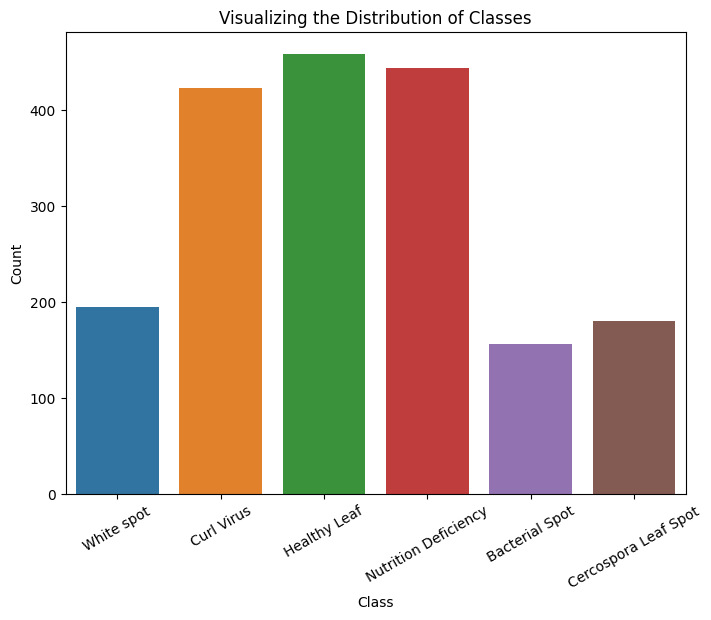

In [3]:
df = pd.DataFrame(list(data.items()), columns=['Class', 'Count'])

plt.figure(figsize=(8,6))
sns.barplot(x='Class', y='Count', data=df)
plt.title("Visualizing the Distribution of Classes")
plt.xticks(rotation=30)
plt.show()

# Visualizing Images per class

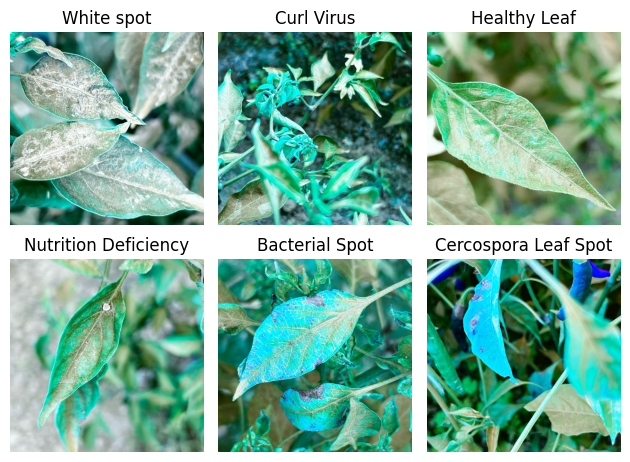

In [4]:
#visualizing images per class
for i,cls in enumerate(classes):
    class_path = os.path.join(dataset_path,cls)
    image = random.choice(os.listdir(class_path))
    img = cv2.imread(os.path.join(class_path,image))
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Dataset preprocessing and augmentation

In [10]:
#setting the base size
IMG_SIZE = 224

#base transform
base_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
])

#augmentation transform
augment_transform = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale = (0.8,1.0)), #random crop + resize,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(25),
    transforms.ColorJitter(brightness = 0.3,contrast = 0.3,saturation = 0.2,hue = 0.1),
    transforms.ToTensor()
])

In [ ]:
class AugmentedImageFolder(datasets.ImageFolder):
    def __init__(self, root, minority_classes, transform_base, transform_aug):
        super().__init__(root=root, transform=None)
        self.minority_classes = set(minority_classes)  # use indices
        self.transform_base = transform_base
        self.transform_aug = transform_aug

    def __getitem__(self, idx):
        path, target = self.samples[idx]
        image = Image.open(path).convert("RGB")

        # Apply augmentation only to minority classes
        if target in self.minority_classes:
            image = self.transform_aug(image)
        else:
            image = self.transform_base(image)

        return image, target

In [16]:
dataset = datasets.ImageFolder(root = dataset_path,transform = base_transform) #initial transform

In [3]:
class BalancedAugmentation(Dataset):
    def __init__(self,samples,transform_base,transform_aug,train=True,balance=True):
        self.base_dataset_samples = samples
        self.transform_base = transform_base
        self.transforn_aug = transform_aug
        self.train = train
        self.balance = balance
        self.targets = [lable for _,label in self.base_dataset_samples]
        self.class_counts = Counter(self.targets)
        self.num_classes = len(self.class_counts)
        print(f"\nOriginal class distribution:")
        for cls, count in sorted(self.class_counts.items()):
            print(f"  Class {cls}: {count} samples")
        #If balancing is enabled and training, create balanced indices
        if self.balance and self.train:
            self._create_balanced_indices()
        else:
            self.indices = list(range(len(self.base_dataset_samples)))
            self.augment_flags = [False] * len(self.indices)
    def _create_balanced_indices(self):
        max_count = max(self.class_counts.values())
        class_indices = {cls: [] for cls in range(self.num_classes)}
        for idx, (_, label) in enumerate(self.base_dataset_samples):
            class_indices[label].append(idx)
        
        self.indices = []
        self.augment_flags = []
        
        for cls in range(self.num_classes):
            cls_indices = class_indices[cls]
            current_count = len(cls_indices)
            
            # Add original samples (no augmentation)
            self.indices.extend(cls_indices)
            self.augment_flags.extend([False] * current_count)
            
            # Add augmented samples if class is minority
            if current_count < max_count:
                num_augmented = max_count - current_count
                augmented_indices = np.random.choice(cls_indices, size=num_augmented, replace=True)
                self.indices.extend(augmented_indices.tolist())
                self.augment_flags.extend([True] * num_augmented)
        
        # Shuffle dataset
        combined = list(zip(self.indices, self.augment_flags))
        np.random.shuffle(combined)
        self.indices, self.augment_flags = zip(*combined)
        self.indices = list(self.indices)
        self.augment_flags = list(self.augment_flags)
        
        print(f"\nBalanced dataset size: {len(self.indices)}")
        print(f"  Original samples: {len(self.base_dataset_samples)}")
        print(f"  Augmented samples: {len(self.indices) - len(self.base_dataset_samples)}")
    
    def __len__(self):
        """Return total number of samples (including augmented)."""
        return len(self.indices)
    
    def __getitem__(self, idx):
        """
        Retrieve one sample (image, label), applying augmentation if flagged.
        """
        actual_idx = self.indices[idx]
        should_augment = self.augment_flags[idx]
        
        # Load image and convert to RGB (ensures 3 channels)
        path, target = self.base_dataset_samples[actual_idx]
        image = Image.open(path).convert("RGB")
        
        # Apply appropriate transform
        if self.train and should_augment:
            image = self.transform_aug(image)
        else:
            image = self.transform_base(image)
        
        return image, target
 

In [4]:
def create_dataloaders(data_path, batch_size=32, train_split=0.8, 
                      balance_train=True, num_workers=4):
    """
    Create train/validation DataLoaders with stratified split and optional class balancing.
    
    Args:
        data_path (str): Root directory of dataset
        batch_size (int): Batch size for DataLoader
        train_split (float): Fraction of dataset to use for training
        balance_train (bool): Whether to balance minority classes in training set
        num_workers (int): Number of worker threads for loading data
    
    Returns:
        train_loader, val_loader, class_names, train_class_counts
    """
    # Load full dataset to get all samples
    full_dataset = datasets.ImageFolder(root=data_path)
    class_names = full_dataset.classes
    
    # Prepare indices and labels for stratified split
    indices = np.arange(len(full_dataset))
    labels = [label for _, label in full_dataset.samples]
    
    # Stratified train/val split (preserves class proportions)
    train_idx, val_idx = train_test_split(
        indices, test_size=(1 - train_split), stratify=labels, random_state=42
    )
    
    # Extract corresponding samples for train and validation
    train_samples = [full_dataset.samples[i] for i in train_idx]
    val_samples = [full_dataset.samples[i] for i in val_idx]
    
    # ------------------------------
    # Training dataset
    # ------------------------------
    print("="*50)
    print("TRAINING SET")
    print("="*50)
    train_dataset = BalancedAugmentedDataset(
        samples=train_samples,
        transform_base=base_transform,
        transform_aug=augment_transform,
        train=True,
        balance=balance_train
    )
    
    # ------------------------------
    # Validation dataset (no augmentation or balancing)
    # ------------------------------
    print("\n" + "="*50)
    print("VALIDATION SET")
    print("="*50)
    val_dataset = BalancedAugmentedDataset(
        samples=val_samples,
        transform_base=base_transform,
        transform_aug=augment_transform,
        train=False,
        balance=False
    )
    
    # Print validation class distribution
    print(f"\nValidation class distribution:")
    for cls, count in sorted(val_dataset.class_counts.items()):
        print(f"  Class {cls}: {count} samples")
    
    # ------------------------------
    # DataLoaders
    # ------------------------------
    train_loader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True,
        num_workers=num_workers, pin_memory=True
    )
    
    val_loader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False,
        num_workers=num_workers, pin_memory=True
    )
    
    return train_loader, val_loader, class_names, train_dataset.class_counts

In [18]:
data_path = "/kaggle/input/chilli-leaf-disease-dataset/Chili Leaf Disease Original Dataset"
train_loader, val_loader, class_names, class_counts = create_dataloaders(
        data_path=data_path,
        batch_size=32,
        train_split=0.8,
        balance_train=True,
        num_workers=4
)

print("\n" + "="*50)
print("SUMMARY")
print("="*50)
print(f"Number of classes: {len(class_names)}")
print(f"Class names: {class_names}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

# Test loading a batch
print("\nTesting batch loading...")
images, labels = next(iter(train_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Labels in batch: {labels.tolist()}")

TRAINING SET

Original class distribution:
  Class 0: 125 samples
  Class 1: 144 samples
  Class 2: 338 samples
  Class 3: 366 samples
  Class 4: 355 samples
  Class 5: 156 samples

Balanced dataset size: 2196
  Original samples: 1484
  Augmented samples: 712

VALIDATION SET

Original class distribution:
  Class 0: 31 samples
  Class 1: 36 samples
  Class 2: 85 samples
  Class 3: 92 samples
  Class 4: 89 samples
  Class 5: 39 samples

Validation class distribution:
  Class 0: 31 samples
  Class 1: 36 samples
  Class 2: 85 samples
  Class 3: 92 samples
  Class 4: 89 samples
  Class 5: 39 samples

SUMMARY
Number of classes: 6
Class names: ['Bacterial Spot', 'Cercospora Leaf Spot', 'Curl Virus', 'Healthy Leaf', 'Nutrition Deficiency', 'White spot']
Training batches: 69
Validation batches: 12

Testing batch loading...
Batch shape: torch.Size([32, 3, 224, 224])
Labels shape: torch.Size([32])
Labels in batch: [4, 0, 3, 1, 4, 4, 3, 3, 2, 1, 1, 5, 3, 3, 3, 2, 3, 1, 0, 5, 3, 2, 3, 3, 0, 1, 5, 1

In [19]:
from collections import Counter

# Check the underlying dataset
train_dataset = train_loader.dataset
class_distribution = Counter([train_dataset[i][1] for i in range(len(train_dataset))])

print("Training set class distribution:")
for cls, count in sorted(class_distribution.items()):
    print(f"  Class {cls}: {count} samples")

Training set class distribution:
  Class 0: 366 samples
  Class 1: 366 samples
  Class 2: 366 samples
  Class 3: 366 samples
  Class 4: 366 samples
  Class 5: 366 samples


# Model training

Epoch [1/10] Train Loss: 1.4444 | Val Loss: 0.9599 | Train Acc: 40.76% | Val Acc: 61.56%
Epoch [2/10] Train Loss: 0.7849 | Val Loss: 0.5555 | Train Acc: 70.77% | Val Acc: 81.45%
Epoch [3/10] Train Loss: 0.5735 | Val Loss: 0.4118 | Train Acc: 78.83% | Val Acc: 84.68%
Epoch [4/10] Train Loss: 0.4542 | Val Loss: 0.4719 | Train Acc: 84.20% | Val Acc: 83.33%
Epoch [5/10] Train Loss: 0.3593 | Val Loss: 0.2593 | Train Acc: 87.34% | Val Acc: 91.13%
Epoch [6/10] Train Loss: 0.3709 | Val Loss: 0.2581 | Train Acc: 86.89% | Val Acc: 91.13%
Epoch [7/10] Train Loss: 0.2602 | Val Loss: 0.2797 | Train Acc: 91.44% | Val Acc: 90.32%
Epoch [8/10] Train Loss: 0.2405 | Val Loss: 0.1603 | Train Acc: 91.26% | Val Acc: 93.82%
Epoch [9/10] Train Loss: 0.2356 | Val Loss: 0.1593 | Train Acc: 92.30% | Val Acc: 96.24%
Epoch [10/10] Train Loss: 0.2079 | Val Loss: 0.1653 | Train Acc: 93.03% | Val Acc: 94.89%


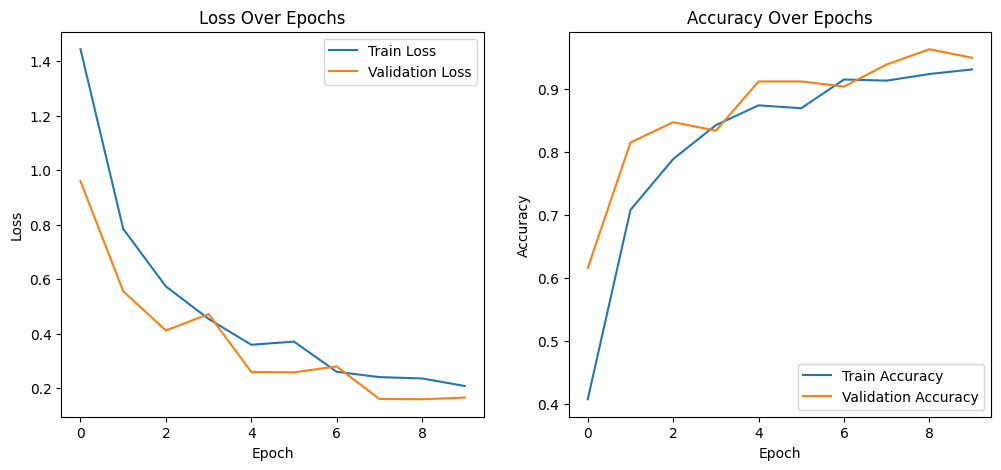

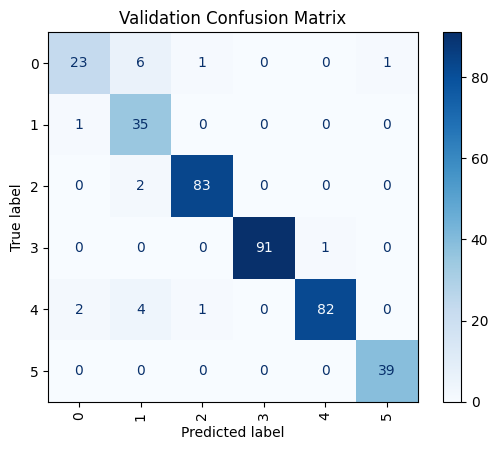

In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# ----------------------------
# Define a simple CNN
# ----------------------------
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()

        # ---- Feature extractor ----
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),   # 3 x 224 x 224 -> 32 x 224 x 224
            nn.ReLU(),
            nn.MaxPool2d(2),                              # 32 x 112 x 112
            nn.Conv2d(32, 64, kernel_size=3, padding=1),  # 64 x 112 x 112
            nn.ReLU(),
            nn.MaxPool2d(2),                              # 64 x 56 x 56
            nn.Conv2d(64, 128, kernel_size=3, padding=1), # 128 x 56 x 56
            nn.ReLU(),
            nn.MaxPool2d(2),                              # 128 x 28 x 28
        )

        # ---- Compute flatten size dynamically ----
        with torch.no_grad():
            dummy = torch.zeros(1, 3, 224, 224)
            out = self.features(dummy)
            flat_features = out.view(1, -1).shape[1]  # e.g. 128*28*28 = 100,352

        # ---- Classifier ----
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flat_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


# ----------------------------
# Setup
# ----------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = len(set([train_loader.dataset[i][1] for i in range(len(train_loader.dataset))]))
model = SimpleCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
num_epochs = 10

# ----------------------------
# Training Loop
# ----------------------------
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # --- Train ---
    model.train()
    total, correct, train_loss = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

    avg_train_loss = train_loss / len(train_loader)
    train_acc = correct / total

    # --- Validate ---
    model.eval()
    val_loss, total, correct = 0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (preds == labels).sum().item()

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc = correct / total

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
          f"Train Acc: {train_acc*100:.2f}% | Val Acc: {val_acc*100:.2f}%")

# ----------------------------
# Visualization
# ----------------------------
# Loss curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Accuracy curves
plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues', xticks_rotation='vertical')
plt.title("Validation Confusion Matrix")
plt.show()
